In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from healthcare_resource_model import HealthcareResourceModel


In [2]:
patient_demo_url='https://drive.googleHealthcareResourceModel/file/d/1_Y2Nia9xf_qEwp_Rd8L70myE7QrstAm-/view?usp=drive_link'
patient_demo_url='https://drive.google.com/uc?id=' + patient_demo_url.split('/')[-2]

patient_visits_url='https://drive.google.com/file/d/13-f5zH3qlVGthN-H7HD24XTOGZ3RmPYe/view?usp=drive_link'
patient_visits_url='https://drive.google.com/uc?id=' + patient_visits_url.split('/')[-2]

In [3]:
patient_demo = pd.read_csv(patient_demo_url)
patient_visit = pd.read_csv(patient_visits_url)

In [4]:
# patient_demo = pd.read_csv("Patient_Demo.csv")
# patient_visit = pd.read_csv("Patient_Hospital_Visit.csv")

In [5]:
patient_demo.shape, patient_visit.shape

((150058, 5), (448600, 9))

In [6]:
patient_data = pd.merge(patient_demo, patient_visit, on=['patient_id', 'institution_id'], how='left')

In [7]:
patient_data.shape

(448146, 12)

In [8]:
patient_data.isna().sum()

institution_id         0
patient_id             0
dob                  202
sex                  287
state             114612
visit_id               0
admitted_at       430193
discharged_at     430093
inserted_at            0
updated_at             0
visit_type             0
type                   0
dtype: int64

## Data Preprocessing:
### Missing Values:

- state: 114612 missing values.
- admitted_at: 430193 missing values.
- discharged_at: 430093 missing values.

The high number of missing values in `admitted_at` and `discharged_at` likely indicates that many of the records are for out-patient visits, where admission and discharge times are not applicable. For these cases, handling missing values might mean leaving them as `NaN`.

For the state column, we need to decide whether to impute, remove, or leave these missing values as they are. Imputation might not be appropriate here due to the nature of the data (geographical information).

### Standardization:
- Date columns (dob, admitted_at, discharged_at, inserted_at, updated_at) have been converted to a consistent datetime format.
- Categorical data (sex, state, visit_type, type) has been converted to lowercase for consistency.

In [9]:
healthcare_model = HealthcareResourceModel()

In [10]:
healthcare_model.load_and_preprocess_data(patient_data)

In [11]:
healthcare_model.data.head()

,institution_id,patient_id,dob,sex,state,visit_id,admitted_at,discharged_at,inserted_at,updated_at,visit_type,type
3,0fa2e546-c292-4060-a05e-beb53fc31e72,2CEW8BKP6,1935-10-09,female,delta,85572466-e5d5-4a44-bdd4-c1c00d056d60,2021-07-29 07:42:17,2021-08-19 08:00:03,2021-07-29,2021-08-19 08:00:03.636032,in-patient,hospital
20,5cc2687c-e6b7-4e76-b7e5-2da37ae08cdb,37V5T987F,1963-07-02,female,lagos,034a7258-5d66-456b-8fd5-1a5a71649172,2021-06-22 05:21:27,2021-06-22 09:11:05,2021-06-22,2021-06-22 09:11:05.958807,in-patient,hospital
21,5cc2687c-e6b7-4e76-b7e5-2da37ae08cdb,37V5T987F,1963-07-02,female,lagos,812efed7-fa91-4ec8-965c-79ec7b8563e5,2021-06-20 18:30:41,2021-06-22 05:09:48,2021-06-20,2021-06-22 05:09:48.747395,in-patient,hospital
28,94a0a068-e4b8-4e3a-8757-5d2a627d6878,3F8JZPC35,1980-12-15,male,akwa ibom,5c6e1fee-dc3e-4875-9c7d-6587eaa2463e,2021-02-18 22:33:49,2021-02-22 10:01:25,2021-02-18,2021-02-22 10:01:25.280476,in-patient,hospital
104,157af2f9-073d-4d75-89e0-b6d214c6d05e,92ZEZ5MD7,1995-09-26,female,ogun,adf5fba1-bbe6-48e1-94cb-ce0c2e9acbde,2021-11-05 12:54:23,2021-11-06 13:48:05,2021-11-05,2021-11-06 13:48:05.643793,in-patient,hospital


- **Remove Rows with Missing `state` Values:** Since there is no straightforward way to impute the state values and they are important for demographic analysis, we'll remove rows where state is missing.

- **Handling `admitted_at` and `discharged_at`:** Given the nature of these fields, 
their absence likely indicates out-patient visits. However, since you've requested to remove missing values, 
we will also remove rows where these fields are missing. This action will primarily leave us with in-patient records.


The removal of rows with missing values in state, admitted_at, or discharged_at has resulted in a dataset with 14,508 records, reduced from the original size. This dataset now primarily contains records of in-patient visits with complete information on state and admission/discharge times.

In [12]:
summary = healthcare_model.dataset_summary()

                Number of Rows      Data Types  Missing Values  Missing Value Percentages
institution_id           14508          object               0                        0.0
patient_id               14508          object               0                        0.0
dob                      14508  datetime64[ns]               0                        0.0
sex                      14508          object               0                        0.0
state                    14508          object               0                        0.0
visit_id                 14508          object               0                        0.0
admitted_at              14508  datetime64[ns]               0                        0.0
discharged_at            14508  datetime64[ns]               0                        0.0
inserted_at              14508  datetime64[ns]               0                        0.0
updated_at               14508  datetime64[ns]               0                        0.0
visit_type

In [14]:
healthcare_model.feature_engineering()

## Feature Engineering

### 1. Temporal Features
- Time of Year: Extract month and day of the week from admitted_at and dob. Certain times of the year or week might have higher resource demands.
- Age: Calculate the age of patients from dob. Age can be a significant factor in healthcare resource utilization.
- Stay Duration: Calculate the length of stay from admitted_at and discharged_at. A longer stay might indicate higher resource utilization.

### 2. Categorical Features
- Label Encoding: Convert categorical variables like sex, state, and visit_type into a format that can be used by machine learning models.
- Aggregation: If there's any categorical data that can be aggregated (e.g., number of visits per state), it might be valuable


### 3. Target Variable
Given the nature the dataset and the task of predicting resource demand in healthcare facilities, the most relevant target variable we can derive from the current dataset is the `length of stay` (which we can calculate as length_of_stay). This is a common proxy for resource utilization in healthcare settings, as longer stays generally indicate more resource usage (medication, bed occupancy, staff time, etc.).

Using the length of stay as the target variable allows us to frame this as a regression problem, where the model predicts a continuous value representing the estimated duration of a patient's stay based on various features like demographic information, admission details, and other patient attributes.

In [15]:
healthcare_model.split_data()

In [21]:
best_model, best_mae = healthcare_model.model_selection()
print(" ")
print(f"Best Model: {best_model}, Best MAE: {best_mae}")


Model: Linear Regression, MAE: 9.594311647427116
Model: Decision Tree Regressor, MAE: 10.108311567466775
Model: Random Forest Regressor, MAE: 8.585068820820547
Model: Gradient Boosting Regressor, MAE: 8.030873129024037
 
Best Model: Gradient Boosting Regressor, Best MAE: 8.030873129024037


In [22]:
healthcare_model.save_best_model(best_model)

MAE: 8.030873129024037, RMSE: 24.300611305383512


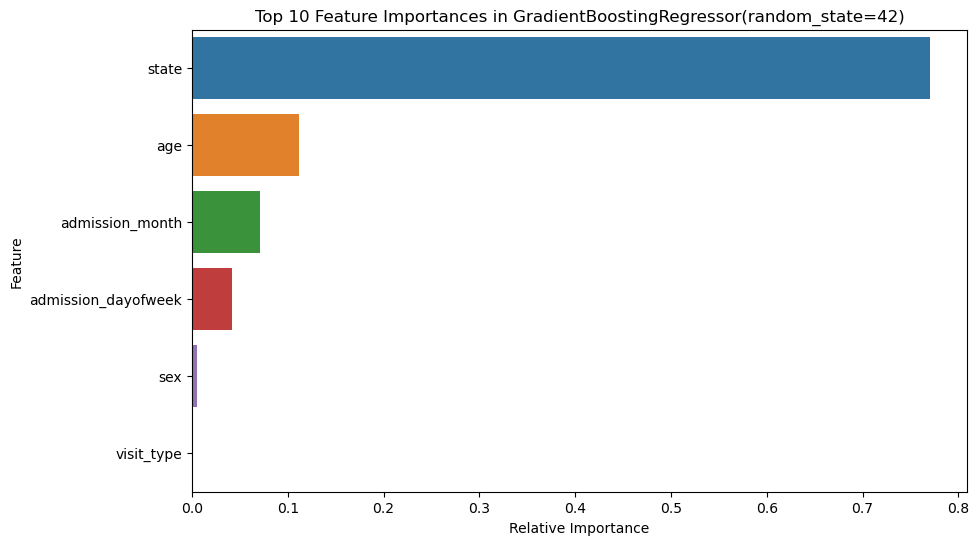

In [23]:
mae, rmse = healthcare_model.evaluate_model()
print(f"MAE: {mae}, RMSE: {rmse}")

healthcare_model.plot_feature_importance()

The feature importance plot shows the most important features in the Gradient Boosting Regressor model for predicting the length of stay in healthcare facilities. These features are the key drivers behind the model's predictions and, by extension, can be seen as influential factors in resource demand.

## Deployment

We can run a simple docker container serving us the model api by running the following

```
docker build -t mymodelapi .
docker run -p 80:80 mymodelapi
```



## Immidiate next steps.

### Testing:

Test the Docker container locally to ensure the FastAPI service runs correctly and can handle prediction requests.
Cloud Deployment:

### Choose a cloud platform (AWS, Azure, Google Cloud) for deployment.
Deploy the container to a cloud service, like AWS ECS or Google Cloud Run, which simplifies deployment and scaling.
CI/CD Setup:


### Monitoring:

Set up monitoring and logging with tools like Evidently AI, or cloud-native solutions to track the application's performance and health.